In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
## Reading and Visualizing data

In [3]:
df = pd.read_csv('Data/anomaly.csv')

In [4]:
# Data Summary 
df.tail()

,Date,Power,Detector,Quality
1456,27-Dec-19,93,8,Good
1457,28-Dec-19,91,10,Good
1458,29-Dec-19,95,8,Good
1459,30-Dec-19,91,10,Good
1460,31-Dec-19,100,12,Good


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Power,1461.0,95.856947,8.435862,61.0,92.0,95.0,98.0,148.0
Detector,1461.0,9.980835,2.174803,5.0,8.0,10.0,11.0,17.0


### Visualizing the Anomaly in the time series
Let's look at the data in time to see whether we can detect the anomlies 

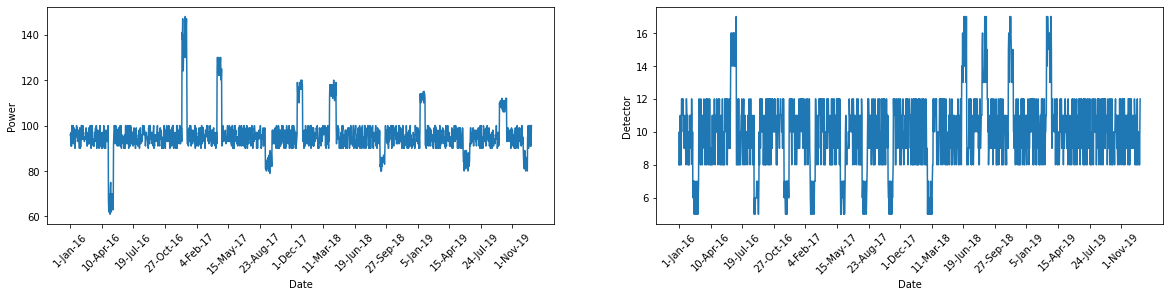

In [6]:
fig,ax = plt.subplots(1,2,figsize=(20,4))
g = sns.lineplot(data=df, x="Date", y="Power",ax=ax[0])
g.set_xticks(range(0,len(df),100)) 
g.set_xticklabels(df['Date'].values[range(0,len(df),100)],rotation=45)
g = sns.lineplot(data=df, x="Date", y="Detector",ax=ax[1])
g.set_xticks(range(0,len(df),100)) 
g.set_xticklabels(df['Date'].values[range(0,len(df),100)],rotation=45)
plt.show()

Let's look at the spread of Good and Bad Signals 

In [7]:
print(df.groupby('Quality')['Quality'].count())

Quality
Bad      407
Good    1054
Name: Quality, dtype: int64


In [8]:
df.drop(['Date'], axis=1, inplace=True)
df.dropna(inplace=True,axis=1)

# Generating mask for Normal amd Anormal data
good_mask = df['Quality']== 'Good' 
bad_mask = df['Quality']== 'Bad' 


df.drop('Quality',axis=1,inplace=True)

df_good = df[good_mask]
df_bad = df[bad_mask]

In [9]:
# This is the feature vector that goes to the neural net
x_good = df_good.values
x_bad = df_bad.values



x_good_train, x_good_test = train_test_split(
        x_good, test_size=0.25, random_state=42)

print("Good train count: {}".format(len(x_good_train)))
print("Good test count: {}".format(len(x_good_test)))

Good train count: 790
Good test count: 264


### Creating the Model Using Keras
Since we are dealing with time series (Only two features), we use only dense layers. The idea is to build an autoencoder model that reconsctruct the good data with low reconstruction loss. In that case the reconstrcution loss (MSE in this case) will increase if the trained model encounter any anomalites

In [10]:
model = Sequential()
model.add(Dense(10, input_dim=x_good.shape[1], activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(x_good.shape[1])) 
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(x_good_train,x_good_train,verbose=1,epochs=100)

Epoch 1/100
25/25 [==============================] - 0s 727us/step - loss: 5186.3564
Epoch 2/100
25/25 [==============================] - 0s 674us/step - loss: 4284.9360
Epoch 3/100
25/25 [==============================] - 0s 611us/step - loss: 3449.7747
Epoch 4/100
25/25 [==============================] - 0s 599us/step - loss: 2609.9351
Epoch 5/100
25/25 [==============================] - 0s 683us/step - loss: 1781.9855
Epoch 6/100
25/25 [==============================] - 0s 591us/step - loss: 1038.2554
Epoch 7/100
25/25 [==============================] - 0s 587us/step - loss: 478.0492
Epoch 8/100
25/25 [==============================] - 0s 620us/step - loss: 156.6949
Epoch 9/100
25/25 [==============================] - 0s 603us/step - loss: 32.6713
Epoch 10/100
25/25 [==============================] - 0s 598us/step - loss: 4.7912
Epoch 11/100
25/25 [==============================] - 0s 615us/step - loss: 1.6163
Epoch 12/100
25/25 [==============================] - 0s 609us/step - los

In [12]:
pred = model.predict(x_good_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,x_good_test))

pred = model.predict(x_good)
score2 = np.sqrt(metrics.mean_squared_error(pred,x_good))

pred = model.predict(x_bad)
score3 = np.sqrt(metrics.mean_squared_error(pred,x_bad))

print("Insample Good Score (RMSE): {}".format(score1))
print("Out of Sample Good Score (RMSE): {}".format(score2))
print("Bad sample Score (RMSE): {}" .format(score3))

Insample Good Score (RMSE): 1.1556683480542782
Out of Sample Good Score (RMSE): 1.1529616121538058
Bad sample Score (RMSE): 2.958696704539722


As can be seen from RMSE of Good sample test and training dataset and RMSE of Bad Samples, we can detect anomalites when the RMSE rises above a certain threshold